In [1]:
import pandas as pd
import numpy as np

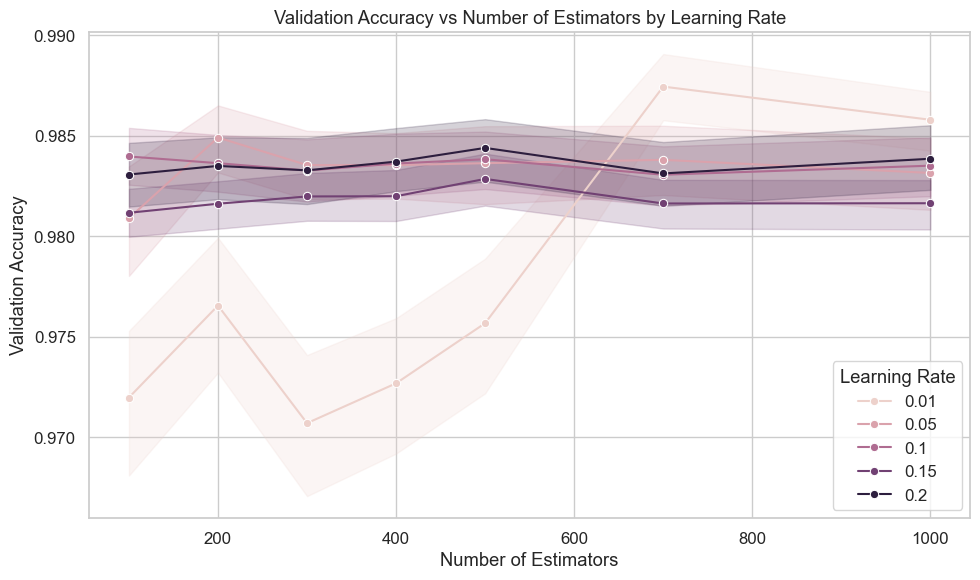

C:\Users\jdrij\AppData\Local\Temp\ipykernel_20840\2234353565.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="max_depth", y="val_accuracy", palette="coolwarm")


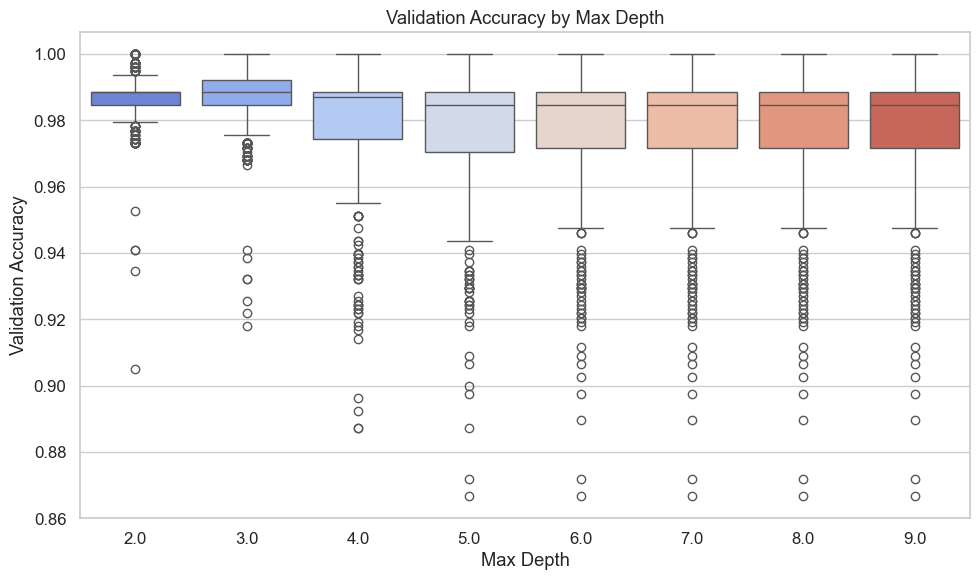

C:\Users\jdrij\AppData\Local\Temp\ipykernel_20840\2234353565.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="subsample", y="val_accuracy", palette="viridis")


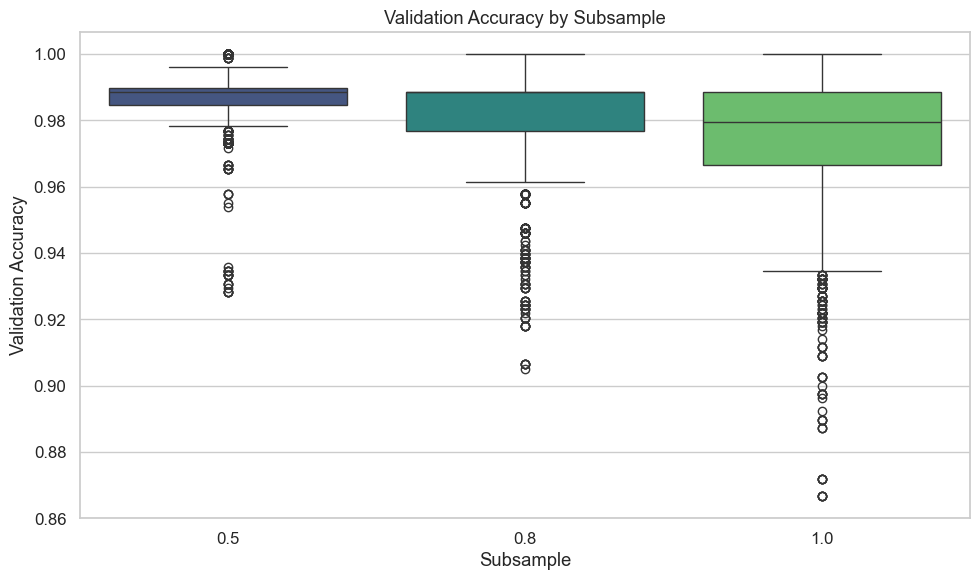

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Zet de stijl voor de plots
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Laad het CSV-bestand in
df = pd.read_csv("xgb_train_val_accuracy_results.csv")  # Pas pad aan indien nodig

# Plot 1: Validation Accuracy vs Number of Estimators (gegroepeerd per learning rate)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="n_estimators", y="val_accuracy", hue="learning_rate", marker="o")
plt.title("Validation Accuracy vs Number of Estimators by Learning Rate")
plt.xlabel("Number of Estimators")
plt.ylabel("Validation Accuracy")
plt.legend(title="Learning Rate")
plt.tight_layout()
plt.show()

# Plot 2: Boxplot van Validation Accuracy per Max Depth
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="max_depth", y="val_accuracy", palette="coolwarm")
plt.title("Validation Accuracy by Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.tight_layout()
plt.show()

# Plot 3: Boxplot van Validation Accuracy per Subsample
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="subsample", y="val_accuracy", palette="viridis")
plt.title("Validation Accuracy by Subsample")
plt.xlabel("Subsample")
plt.ylabel("Validation Accuracy")
plt.tight_layout()
plt.show()


In [ ]:
train_df = pd.read_csv(r'C:\Users\jdrij\OneDrive\Bureaublad\Master\ML_Github\ML4QS-project\data\train_df.csv')
# test_df = pd.read_csv(r'C:\Users\jdrij\OneDrive\Bureaublad\Master\ML_Github\ML4QS-project\data\test_df.csv')

In [ ]:
def split_train_val(df, n_groups=5, val_group=0):
    grouped = []

    for label in df['transport_mode'].unique():
        df_label = df[df['transport_mode'] == label].copy()
        df_label = df_label.sort_values(by='Time').reset_index(drop=True)  # <-- chronologische volgorde

        # Verdeel in ongeveer gelijke groepen
        split_groups = np.array_split(df_label, n_groups)
        for i, group in enumerate(split_groups):
            group['group'] = i
            grouped.append(group)

    df_grouped = pd.concat(grouped).reset_index(drop=True)

    val_set = df_grouped[df_grouped['group'] == val_group]
    train_set = df_grouped[df_grouped['group'] != val_group]

    return train_set.drop(columns=['group']), val_set.drop(columns=['group'])

# Voorbeeld gebruik:
train_df_hyper, val_df_hyper = split_train_val(train_df, val_group=0)

In [ ]:
train_df_hyper.shape

In [ ]:
val_df_hyper.shape

XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Stap 1: Voorbereiden van data
# -----------------------------
X_train_xgb = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_xgb = train_df_hyper['transport_mode']

X_val_xgb = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_xgb = val_df_hyper['transport_mode']

# -----------------------------
# Stap 2: Encode labels
# -----------------------------
le_xgb = LabelEncoder()
y_train_enc_xgb = le_xgb.fit_transform(y_train_xgb)
y_val_enc_xgb = le_xgb.transform(y_val_xgb)

print("Label mapping (XGB):", dict(zip(le_xgb.classes_, le_xgb.transform(le_xgb.classes_))))

# -----------------------------
# Stap 3: Combineer train en val
# -----------------------------
X_combined_xgb = pd.concat([X_train_xgb, X_val_xgb], axis=0)
y_combined_xgb = np.concatenate([y_train_enc_xgb, y_val_enc_xgb])

val_fold_xgb = [-1] * len(X_train_xgb) + [0] * len(X_val_xgb)
ps_xgb = PredefinedSplit(val_fold_xgb)

# -----------------------------
# Stap 4: Hyperparameterraster
# -----------------------------

param_grid_xgb = {
    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_depth': [2, 3, 4, 5, 6],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [200],
    'max_depth': [4],
    'learning_rate': [0.01],
    'reg_alpha': [0, 1, 5, 10],
    'reg_lambda': [0, 1, 5, 10],
}

# -----------------------------
# Stap 5: Grid Search
# -----------------------------
model_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    n_jobs=-1,
    cv=ps_xgb,
    verbose=2,
    return_train_score=True
)

grid_search_xgb.fit(X_combined_xgb, y_combined_xgb)

# -----------------------------
# Stap 6: Toon train en val scores
# -----------------------------
results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

print("\nTrain/Validation scores per parameter set (XGB):\n")
for i in range(len(results_xgb)):
    params = results_xgb.loc[i, 'params']
    train_acc = results_xgb.loc[i, 'mean_train_score']
    val_acc = results_xgb.loc[i, 'mean_test_score']
    print(f"Parameters: {params}")
    print(f"→ Train accuracy: {train_acc:.4f}, Val accuracy: {val_acc:.4f}\n")

# -----------------------------
# Beste combinatie + accuracies
# -----------------------------
print("Beste hyperparameters (XGB):")
print(grid_search_xgb.best_params_)

best_params_xgb = grid_search_xgb.best_params_
best_train_acc_xgb = results_xgb.loc[grid_search_xgb.best_index_, 'mean_train_score']
best_val_acc_xgb = results_xgb.loc[grid_search_xgb.best_index_, 'mean_test_score']

print("\nBeste hyperparameters (XGB):")
print(best_params_xgb)
print(f"→ Train Accuracy:      {best_train_acc_xgb:.4f}")
print(f"→ Validation Accuracy: {best_val_acc_xgb:.4f}")


In [ ]:
# results_to_save_xgb = results_xgb[[
#     'params',
#     'mean_train_score',
#     'mean_test_score',  # test = validation in GridSearchCV
#     'rank_test_score'
# ]]

# # Expand the 'params' dictionary into separate columns
# params_df_xgb = results_xgb['params'].apply(pd.Series)

# # Combine everything into one DataFrame
# full_results_df_xgb = pd.concat([
#     params_df_xgb,
#     results_to_save_xgb.drop(columns=['params'])
# ], axis=1)

# # Rename for clarity
# full_results_df_xgb.rename(columns={
#     'mean_train_score': 'train_accuracy',
#     'mean_test_score': 'val_accuracy'
# }, inplace=True)

# # Save to CSV
# full_results_df_xgb.to_csv("xgb_train_val_accuracy_results_klein.csv", index=False)

# print("Train and validation accuracy results saved to 'xgb_train_val_accuracy_results.csv'")

Randomforest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Stap 1: Voorbereiden van data
# -----------------------------
X_train_rf = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_rf = train_df_hyper['transport_mode']

X_val_rf = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_rf = val_df_hyper['transport_mode']

# -----------------------------
# Stap 2: Encode labels
# -----------------------------
le_rf = LabelEncoder()
y_train_enc_rf = le_rf.fit_transform(y_train_rf)
y_val_enc_rf = le_rf.transform(y_val_rf)

print("Label mapping (RF):", dict(zip(le_rf.classes_, le_rf.transform(le_rf.classes_))))

# -----------------------------
# Stap 3: Combineer train en val
# -----------------------------
X_combined_rf = pd.concat([X_train_rf, X_val_rf], axis=0)
y_combined_rf = np.concatenate([y_train_enc_rf, y_val_enc_rf])

val_fold_rf = [-1] * len(X_train_rf) + [0] * len(X_val_rf)
ps_rf = PredefinedSplit(val_fold_rf)

# -----------------------------
# Stap 4: Hyperparameterraster
# -----------------------------
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_leaf': [2, 10, 50, 100],
}

# -----------------------------
# Stap 5: Grid Search
# -----------------------------
model_rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring='accuracy',
    n_jobs=-1,
    cv=ps_rf,
    verbose=2,
    return_train_score=True
)

grid_search_rf.fit(X_combined_rf, y_combined_rf)

# -----------------------------
# Stap 6: Resultaten tonen
# -----------------------------
results_rf = pd.DataFrame(grid_search_rf.cv_results_)

print("\nTrain/Validation scores per parameter set (RF):\n")
for i in range(len(results_rf)):
    params = results_rf.loc[i, 'params']
    train_acc = results_rf.loc[i, 'mean_train_score']
    val_acc = results_rf.loc[i, 'mean_test_score']
    print(f"Parameters: {params}")
    print(f"→ Train accuracy: {train_acc:.4f}, Val accuracy: {val_acc:.4f}\n")

# -----------------------------
# Beste combinatie + accuracies
# -----------------------------
print("Beste hyperparameters (RF):")
print(grid_search_rf.best_params_)

best_params_rf = grid_search_rf.best_params_
best_train_acc_rf = results_rf.loc[grid_search_rf.best_index_, 'mean_train_score']
best_val_acc_rf = results_rf.loc[grid_search_rf.best_index_, 'mean_test_score']

print("\nBeste hyperparameters (Random Forest):")
print(best_params_rf)
print(f"→ Train Accuracy:      {best_train_acc_rf:.4f}")
print(f"→ Validation Accuracy: {best_val_acc_rf:.4f}")


In [ ]:
# results_to_save_rf = results_rf[[
#     'params',
#     'mean_train_score',
#     'mean_test_score',  # test = validation in GridSearchCV
#     'rank_test_score'
# ]]

# # Expand the 'params' dictionary into separate columns
# params_df_rf = results_rf['params'].apply(pd.Series)

# # Combine everything into one DataFrame
# full_results_df_rf = pd.concat([
#     params_df_rf,
#     results_to_save_rf.drop(columns=['params'])
# ], axis=1)

# # Rename for clarity
# full_results_df_rf.rename(columns={
#     'mean_train_score': 'train_accuracy',
#     'mean_test_score': 'val_accuracy'
# }, inplace=True)

# # Save to CSV
# full_results_df_rf.to_csv("rf_train_val_accuracy_results.csv", index=False)

# print("Train and validation accuracy results saved to 'rf_train_val_accuracy_results.csv'")

Catboost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Stap 1: Voorbereiden van data
# -----------------------------
X_train_cb = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_cb = train_df_hyper['transport_mode']

X_val_cb = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_cb = val_df_hyper['transport_mode']

# -----------------------------
# Stap 2: Encode labels
# -----------------------------
le_cb = LabelEncoder()
y_train_enc_cb = le_cb.fit_transform(y_train_cb)
y_val_enc_cb = le_cb.transform(y_val_cb)

print("Label mapping (CatBoost):", dict(zip(le_cb.classes_, le_cb.transform(le_cb.classes_))))

# -----------------------------
# Stap 3: Combineer train en val
# -----------------------------
X_combined_cb = pd.concat([X_train_cb, X_val_cb], axis=0)
y_combined_cb = np.concatenate([y_train_enc_cb, y_val_enc_cb])

val_fold_cb = [-1] * len(X_train_cb) + [0] * len(X_val_cb)
ps_cb = PredefinedSplit(val_fold_cb)

# -----------------------------
# Stap 4: Hyperparameterraster
# -----------------------------
param_grid_cb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'depth': [2, 3, 4, 5, 6],
}

# -----------------------------
# Stap 5: Grid Search
# -----------------------------
model_cb = CatBoostClassifier(
    verbose=0,
    random_state=42,
    loss_function='MultiClass'
)

grid_search_cb = GridSearchCV(
    estimator=model_cb,
    param_grid=param_grid_cb,
    scoring='accuracy',
    cv=ps_cb,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search_cb.fit(X_combined_cb, y_combined_cb)

# -----------------------------
# Stap 6: Resultaten tonen
# -----------------------------
results_cb = pd.DataFrame(grid_search_cb.cv_results_)

print("\nTrain/Validation scores per parameter set (CatBoost):\n")
for i in range(len(results_cb)):
    params = results_cb.loc[i, 'params']
    train_acc = results_cb.loc[i, 'mean_train_score']
    val_acc = results_cb.loc[i, 'mean_test_score']
    print(f"Parameters: {params}")
    print(f"→ Train accuracy: {train_acc:.4f}, Val accuracy: {val_acc:.4f}\n")

# -----------------------------
# Beste combinatie + accuracies
# -----------------------------
print("Beste hyperparameters (CatBoost):")
print(grid_search_cb.best_params_)

best_params_cb = grid_search_cb.best_params_
best_train_acc_cb = results_cb.loc[grid_search_cb.best_index_, 'mean_train_score']
best_val_acc_cb = results_cb.loc[grid_search_cb.best_index_, 'mean_test_score']

print("\nBeste hyperparameters (CatBoost):")
print(best_params_cb)
print(f"→ Train Accuracy:      {best_train_acc_cb:.4f}")
print(f"→ Validation Accuracy: {best_val_acc_cb:.4f}")


In [ ]:
# results_to_save_cb = results_cb[[
#     'params',
#     'mean_train_score',
#     'mean_test_score',  # test = validation in GridSearchCV
#     'rank_test_score'
# ]]

# # Expand the 'params' dictionary into separate columns
# params_df_cb = results_cb['params'].apply(pd.Series)

# # Combine everything into one DataFrame
# full_results_df_cb = pd.concat([
#     params_df_cb,
#     results_to_save_cb.drop(columns=['params'])
# ], axis=1)

# # Rename for clarity
# full_results_df_cb.rename(columns={ 
#     'mean_train_score': 'train_accuracy',
#     'mean_test_score': 'val_accuracy'
# }, inplace=True)

# # Save to CSV
# full_results_df_cb.to_csv("cb_train_val_accuracy_results.csv", index=False)

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# -----------------------------
# Prepare data
# -----------------------------
X_train_knn = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_knn = train_df_hyper['transport_mode']

X_val_knn = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_knn = val_df_hyper['transport_mode']

# Encode labels
le_knn = LabelEncoder()
y_train_enc_knn = le_knn.fit_transform(y_train_knn)
y_val_enc_knn = le_knn.transform(y_val_knn)

# Combine and scale
X_combined_knn = pd.concat([X_train_knn, X_val_knn], axis=0)
y_combined_knn = np.concatenate([y_train_enc_knn, y_val_enc_knn])

scaler_knn = StandardScaler()
X_combined_knn_scaled = scaler_knn.fit_transform(X_combined_knn)

# Predefined split
val_fold_knn = [-1] * len(X_train_knn) + [0] * len(X_val_knn)
ps_knn = PredefinedSplit(val_fold_knn)

# -----------------------------
# Define hyperparameter grid
# -----------------------------
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan and Euclidean
}

# -----------------------------
# Grid Search
# -----------------------------
model_knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=model_knn,
    param_grid=param_grid_knn,
    scoring='accuracy',
    n_jobs=-1,
    cv=ps_knn,
    verbose=2,
    return_train_score=True
)

grid_search_knn.fit(X_combined_knn_scaled, y_combined_knn)

# -----------------------------
# Results
# -----------------------------
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Best parameters + accuracies
best_params_knn = grid_search_knn.best_params_
best_train_acc_knn = results_knn.loc[grid_search_knn.best_index_, 'mean_train_score']
best_val_acc_knn = results_knn.loc[grid_search_knn.best_index_, 'mean_test_score']

print("\nBeste hyperparameters (KNN):")
print(best_params_knn)
print(f"→ Train Accuracy:      {best_train_acc_knn:.4f}")
print(f"→ Validation Accuracy: {best_val_acc_knn:.4f}")


In [ ]:
results_to_save_knn = results_knn[[
    'params',
    'mean_train_score',
    'mean_test_score',  # test = validation in GridSearchCV
    'rank_test_score'
]]

# Expand the 'params' dictionary into separate columns
params_df_knn = results_knn['params'].apply(pd.Series)

# Combine everything into one DataFrame
full_results_df_knn = pd.concat([
    params_df_knn,
    results_to_save_knn.drop(columns=['params'])
], axis=1)

# Rename for clarity
full_results_df_knn.rename(columns={
    'mean_train_score': 'train_accuracy',
    'mean_test_score': 'val_accuracy'
}, inplace=True)

# Save to CSV
full_results_df_knn.to_csv("knn_train_val_accuracy_results.csv", index=False)

Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# -----------------------------
# Prepare data
# -----------------------------
X_train_logreg = train_df_hyper.drop(columns=['transport_mode', 'Time'])
y_train_logreg = train_df_hyper['transport_mode']

X_val_logreg = val_df_hyper.drop(columns=['transport_mode', 'Time'])
y_val_logreg = val_df_hyper['transport_mode']

# Encode target
le_logreg = LabelEncoder()
y_train_enc_logreg = le_logreg.fit_transform(y_train_logreg)
y_val_enc_logreg = le_logreg.transform(y_val_logreg)

# Combine train and val
X_combined_logreg = pd.concat([X_train_logreg, X_val_logreg], axis=0)
y_combined_logreg = np.concatenate([y_train_enc_logreg, y_val_enc_logreg])

# Scaling
scaler_logreg = StandardScaler()
X_combined_scaled_logreg = scaler_logreg.fit_transform(X_combined_logreg)

# Predefined split
val_fold_logreg = [-1] * len(X_train_logreg) + [0] * len(X_val_logreg)
ps_logreg = PredefinedSplit(val_fold_logreg)

# -----------------------------
# Define hyperparameter grid
# -----------------------------
param_grid_logreg = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

# -----------------------------
# Grid Search
# -----------------------------
model_logreg = LogisticRegression()
grid_search_logreg = GridSearchCV(
    estimator=model_logreg,
    param_grid=param_grid_logreg,
    scoring='accuracy',
    n_jobs=-1,
    cv=ps_logreg,
    verbose=2,
    return_train_score=True
)

grid_search_logreg.fit(X_combined_scaled_logreg, y_combined_logreg)

# -----------------------------
# Results
# -----------------------------
results_logreg = pd.DataFrame(grid_search_logreg.cv_results_)

# Best parameters + train/val accuracy
best_params_logreg = grid_search_logreg.best_params_
best_train_acc_logreg = results_logreg.loc[grid_search_logreg.best_index_, 'mean_train_score']
best_val_acc_logreg = results_logreg.loc[grid_search_logreg.best_index_, 'mean_test_score']

print("\nBeste hyperparameters (Logistic Regression):")
print(best_params_logreg)
print(f"→ Train Accuracy:      {best_train_acc_logreg:.4f}")
print(f"→ Validation Accuracy: {best_val_acc_logreg:.4f}")

In [ ]:
results_to_save_logreg = results_logreg[[
    'params',
    'mean_train_score',
    'mean_test_score',  # test = validation in GridSearchCV
    'rank_test_score'
]]

# Expand the 'params' dictionary into separate columns
params_df_logreg = results_logreg['params'].apply(pd.Series)

# Combine everything into one DataFrame
full_results_df_logreg = pd.concat([
    params_df_logreg,
    results_to_save_logreg.drop(columns=['params'])
], axis=1)

# Rename for clarity
full_results_df_logreg.rename(columns={
    'mean_train_score': 'train_accuracy',
    'mean_test_score': 'val_accuracy'
}, inplace=True)

# Save to CSV
full_results_df_logreg.to_csv("logreg_train_val_accuracy_results.csv", index=False)